# Attentional sequence-to-sequence model

Code for sequence-to-sequence model with attentional decoder. Uncomment parts to add/remove attention.

## Libraries

In [1]:
pip install num2words

In [0]:
# Import libaries:

import numpy as np
import random
import num2words

# For plotting:
import matplotlib.pyplot as plt
%matplotlib inline

# Pytorch stuff:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

cuda = torch.cuda.is_available()

## Data

In [3]:
# Generate dataset based on maximum sequence length (interval)
interval = 5
words = [str(i) for i in range(1,interval+1)] + [num2words.num2words(i) for i in range(1,interval+1)]
# Vocabulary dictionaries:
idx2word = dict(zip(range(len(words)+3),  ['pad_val'] + words + ['SOS'] + ['EOS']))
word2idx = dict(zip(['pad_val'] + words + ['SOS'] + ['EOS'] ,range(len(words)+3)))
n_char = len(words)+3
vocab_size =n_char

# Function to converte from number to string:
def word2idx_func(input_words):
    return [word2idx[i] for i in input_words]
def idx2word_func(input_idx):
    return [idx2word[i] for i in input_idx]

data_size = 50000
inputs = []
targets = []
for i in range(data_size):
  # For contiuous sequences:
  # length = random.choice(range(1,interval))
  # choice = random.choice(range(0,interval-length))
  # inputs.append(words[choice:choice+length])
  # targets.append(words[interval+choice:interval+choice+length]+['EOS'])
  
  # For random sequences:
    length = random.choice(range(1,interval))
    in_data=[]
    out_data = []
    for j in range(length):
        choice = random.choice(range(0,interval))
        in_data.append(words[choice])
        out_data.append(words[choice+interval])
    inputs.append(in_data)
    targets.append(out_data+['EOS'])

# Partition dataset into training and validation data:
from sklearn.model_selection import train_test_split
input_data_train, input_data_val, target_data_train, target_data_val = train_test_split(inputs, targets, test_size=0.33, random_state=42)
del inputs, targets

print(input_data_train[:3])
print(target_data_train[:3])
print(len(input_data_train))
print(len(input_data_val))

[['5', '1', '5'], ['5', '1'], ['4', '4']]
[['five', 'one', 'five', 'EOS'], ['five', 'one', 'EOS'], ['four', 'four', 'EOS']]
33500
16500


## Network

In [4]:
embed_dim = 128
hidden_size = 256

input_size_enc = n_char
hidden_size_enc = hidden_size

input_size_dec = hidden_size_enc
hidden_size_dec = hidden_size

output_size = vocab_size
batch_size= 5

emb = nn.Embedding(vocab_size, embed_dim)
emb.cuda()

########## Define Encoder
class Encoder(nn.Module):
    def __init__(self, hidden_size,batch_size_enc, bidirectional):
        super(Encoder, self).__init__()
        self.batch_size = batch_size_enc
        self.hidden_size = hidden_size
        self.bidirectional=bidirectional
        
        self.num_directions = 1
        if bidirectional == True:
            self.num_directions = 2
        
        self.gru = nn.GRU(embed_dim, hidden_size, bidirectional=bidirectional)
        
    def forward(self, x, hidden): 
        ls = [len(i) for i in x]
        x_padded = torch.nn.utils.rnn.pad_sequence(x)
        x_embedded = emb(x_padded)
        x = torch.nn.utils.rnn.pack_padded_sequence(x_embedded, ls, False, False)
        x = x.cuda()
        output_gru, hidden = self.gru(x, hidden)
        output_padded,_ = torch.nn.utils.rnn.pad_packed_sequence(output_gru, batch_first=False)
        if self.bidirectional == True:
            output = output_padded[:, :, :self.hidden_size] + output_padded[:, :, self.hidden_size:]
            last_hidden = (hidden[0, :, :] + hidden[1, : ,:]).unsqueeze(0)
        else:
            output = output_padded
            last_hidden = hidden
        return output, last_hidden

    def initHidden(self):
        return torch.zeros(self.num_directions, self.batch_size, self.hidden_size)


###### Define Decoder
class Decoder(nn.Module):
    def __init__(self, hidden_size,input_size,batch_size_dec):
        super(Decoder, self).__init__()
        self.batch_size=batch_size_dec
        self.hidden_size = hidden_size
        self.dropout_p = 0.1

        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(embed_dim, hidden_size)
        self.out_lin = nn.Linear(in_features=hidden_size, out_features=output_size)

        # For attention:
        self.vector_v = nn.Linear(hidden_size,1,bias=False) #weighting after tanh activation (v^t in the paper)
        self.w_h = nn.Linear(hidden_size,hidden_size, bias=False) #weights for encoder hidden states (W_h in the paper)
        self.w_s = nn.Linear(hidden_size, hidden_size, bias=True) #weights for decoder hidden states (W_s in the paper and the bias represent b_attn)
        self.softmax = nn.Softmax(dim=0)  

        self.v_lin_1 = nn.Linear(hidden_size*2,hidden_size)
        self.v_lin_2 = nn.Linear(hidden_size,output_size)

    def forward(self, x, hidden, h_i):   
        x = emb(x)
        x = F.relu(x)
        output, s_t = self.gru(x, hidden)
        
        ### NO ATTENTION ###
        # output = self.out_lin(output)

        ### ATTENTION ###
        w_h_i = self.w_h(h_i)
        w_s_t = self.w_s(s_t)
        e_i = self.vector_v(torch.tanh(w_h_i + w_s_t))
        att_dist = self.softmax(e_i)
        att_dist = att_dist.permute(1,2,0)
        h_i = h_i.permute(1,0,2)
        h_t = torch.matmul(att_dist,h_i)
        h_t=h_t.permute(1,0,2)
        temp = torch.cat((s_t,h_t),dim=2).cuda()
        p_vocab = self.v_lin_2(self.v_lin_1(temp))
        output = p_vocab

        return output, s_t

    def initHidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size)

# Choose the shape of the encoder
net_encoder = Encoder(hidden_size = hidden_size_enc, batch_size_enc=batch_size, bidirectional=False)
# Choose the shape of the encoder
net_decoder = Decoder(input_size = input_size_dec, hidden_size = hidden_size_dec, batch_size_dec=batch_size)

if cuda:
    net_encoder = net_encoder.cuda()
    net_decoder = net_decoder.cuda()

print(net_encoder)
print(net_decoder)

Encoder(
  (gru): GRU(128, 256)
)
Decoder(
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(128, 256)
  (out_lin): Linear(in_features=256, out_features=13, bias=True)
  (vector_v): Linear(in_features=256, out_features=1, bias=False)
  (w_h): Linear(in_features=256, out_features=256, bias=False)
  (w_s): Linear(in_features=256, out_features=256, bias=True)
  (softmax): Softmax(dim=0)
  (v_lin_1): Linear(in_features=512, out_features=256, bias=True)
  (v_lin_2): Linear(in_features=256, out_features=13, bias=True)
)


## Checking the forward pass

In [5]:
input_test_batch = input_data_train[:batch_size]
target_test_batch = target_data_train[:batch_size]

print(input_test_batch)
print(target_test_batch)

encoder_hidden = net_encoder.initHidden()

temp=map(torch.tensor,map(word2idx_func, input_test_batch))
print('temp: ',temp)
enc_input = list(temp)
encoder_input=[]
for item in enc_input:
    item = item.cuda()
    encoder_input.append(item)
    
outputs_enc, hidden = net_encoder(encoder_input, encoder_hidden.cuda())
print('end_encoder')

decoder_hidden = hidden
decoder_input = torch.tensor([[word2idx['SOS']]*batch_size]).cuda()
y, decoder_hidden = net_decoder(decoder_input, decoder_hidden, outputs_enc)
new_y=y.view(-1,n_char)

[['5', '1', '5'], ['5', '1'], ['4', '4'], ['5', '2', '5'], ['1', '4', '3', '4']]
[['five', 'one', 'five', 'EOS'], ['five', 'one', 'EOS'], ['four', 'four', 'EOS'], ['five', 'two', 'five', 'EOS'], ['one', 'four', 'three', 'four', 'EOS']]
temp:  <map object at 0x7f0ed3fff748>
end_encoder


## Training

In [0]:
## Defining loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=word2idx['pad_val'])

LEARNING_RATE = 0.01
optimizer_encoder = optim.SGD(net_encoder.parameters(), lr=LEARNING_RATE)
optimizer_decoder = optim.SGD(net_decoder.parameters(), lr=LEARNING_RATE)

Epoch: 0
Batch: 1 of 10. Loss: tensor(12.8520, device='cuda:0', grad_fn=<AddBackward0>)
Batch: 2 of 10. Loss: tensor(0.1544, device='cuda:0', grad_fn=<AddBackward0>)
Batch: 3 of 10. Loss: tensor(0.0059, device='cuda:0', grad_fn=<AddBackward0>)
Batch: 4 of 10. Loss: tensor(0.0067, device='cuda:0', grad_fn=<AddBackward0>)
Batch: 5 of 10. Loss: tensor(0.0098, device='cuda:0', grad_fn=<AddBackward0>)
Batch: 6 of 10. Loss: tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
Batch: 7 of 10. Loss: tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
Batch: 8 of 10. Loss: tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
Batch: 9 of 10. Loss: tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)
Batch: 10 of 10. Loss: tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1
Batch: 1 of 10. Loss: tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
Batch: 2 of 10. Loss: tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
Batch: 3 of 10. Loss: tensor(0.0002, device=

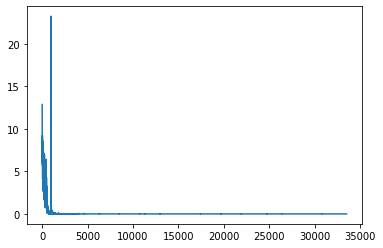

In [7]:
epoch = 5
total_loss = []
N = len(input_data_train)-batch_size
n_batches = N/batch_size

net_encoder.train()
net_decoder.train()

for e in range(epoch):
  print('Epoch: ' + str(e))

  for idx in range(0,N,batch_size):
      input_batch_temp = list(map(torch.tensor,map(word2idx_func,input_data_train[idx:idx+batch_size])))
      input_batch=[]
      for item in input_batch_temp:
          item = item.cuda()
          input_batch.append(item)
      target_batch =list(map(torch.tensor,map(word2idx_func,target_data_train[idx:idx+batch_size])))
      target_batch = nn.utils.rnn.pad_sequence(target_batch).cuda()
      
      loss = 0

      encoder_hidden = net_encoder.initHidden().cuda()
      output_enc, encoder_hidden = net_encoder(input_batch,encoder_hidden)

      padded_tensor_target = target_batch
      decoder_hidden = encoder_hidden
      decoder_input = torch.tensor([[word2idx['SOS']]*batch_size]).cuda()
      for j in range(len(target_batch)):
          y_predicted, decoder_hidden = net_decoder(decoder_input,decoder_hidden,output_enc)        
          loss += criterion(y_predicted.view(-1,n_char),target_batch[j].type(torch.LongTensor).cuda())
          decoder_input = target_batch[j].type(torch.LongTensor).view(1,-1).cuda() #teacher forced

      optimizer_encoder.zero_grad()
      optimizer_decoder.zero_grad()
      loss.backward()
      optimizer_encoder.step()
      optimizer_decoder.step()

      total_loss.append(loss)
      if idx % round(N/10) == 0:
        print( 'Batch: ' + str( int( idx/round(N/10)) +1 )+ ' of 10. Loss: ' + str(loss) )

plt.plot(total_loss);

## Validation

In [8]:
net_encoder.eval()
net_decoder.eval()

accuracy = 0
max_output_char = interval+1
N = len(input_data_val)-batch_size
print('N: ', N)

for idx in range(0,N,batch_size):
    if idx % 5000 == 0:
        print('idx: ', idx )
    input_batch_temp = list(map(torch.tensor,map(word2idx_func,input_data_val[idx:idx+batch_size])))  
    input_batch = []
    for item in input_batch_temp:
        item = item.cuda()
        input_batch.append(item)
        
    target_batch = target_data_val[idx:idx+batch_size]
    
    encoder_hidden = net_encoder.initHidden().cuda()
    output_enc, encoder_hidden = net_encoder(input_batch,encoder_hidden)

    # Looping over the i'th element of each batch
    decoder_hidden = encoder_hidden
    decoder_input = torch.tensor([[word2idx['SOS']]*batch_size]).cuda()
    flag = True
    counter = 0
    predicted_outputs = [[] for i in range(batch_size)]
    while counter <= max_output_char and flag:
        y_predicted, decoder_hidden = net_decoder(decoder_input,decoder_hidden,output_enc)   
        topv, topi = y_predicted.topk(1)
        y = topi; decoder_input = y.view(1,-1)
        y=y.view(batch_size)
        for i in range(batch_size):
          # Only append if list is empty or last element of list is not 'EOS'
            if not predicted_outputs[i]:             
                predicted_outputs[i].append(idx2word[y[i].item()])
            elif predicted_outputs[i][-1] != 'EOS':
                predicted_outputs[i].append(idx2word[y[i].item()])
        if all(x == 'EOS' for x in [predicted_outputs[i][-1] for i in range(batch_size)]):
            flag = False
        counter +=1
    
    # For printing wrong predictions:
    for idx in range(len(predicted_outputs)):
        if predicted_outputs[idx] != target_batch[idx]:
            # Only print the wrong ones...
            print('Wrong prediction on: ')
            print('Input:' + str(input_batch[idx]) + '\n Target: ' + str(target_batch[idx]) + ',\n Output: ' + str(predicted_outputs[idx]))
  
    accuracy += sum([predicted_outputs[i] == target_batch[i] for i in range(batch_size)])

print('Accuracy: '+ str(accuracy/N*100) + '%')

N:  16495
idx:  0
idx:  5000
idx:  10000
idx:  15000
Accuracy: 100.0%


## Summary

In [9]:
interval

5

In [10]:
print(loss)

tensor(6.1417e-05, device='cuda:0', grad_fn=<AddBackward0>)


In [11]:
print('Accuracy: '+ str(accuracy/N*100) + '%')

Accuracy: 100.0%
